In [1]:
import os
import sys

sys.path.append('../')

In [2]:
import torch
import numpy as np
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.metrics import accuracy_score

In [3]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation

In [4]:
from pydil.visualization.gauss import plot_cov_ellipse
from pydil.dadil.gmm_dictionary import GaussianMixtureDictionary
from pydil.toy_datasets.domain_adaptation.msda import msda_toy_example

2023-07-20 10:18:35.725310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 10:18:35.908470: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-20 10:18:35.939461: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-20 10:18:36.510994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [5]:
cmap = plt.get_cmap('coolwarm')
c1 = cmap(0)
c2 = cmap(256)
colors = [c1, c2]

In [6]:
c1, c2

((0.2298057, 0.298717966, 0.753683153, 1.0),
 (0.705673158, 0.01555616, 0.150232812, 1.0))

In [7]:
def estimate_proportions(Y):
    y = Y.argmax(dim=1)
    u, c = torch.unique(y, return_counts=True)
    
    return c / c.sum()

In [8]:
n_dim = 2
n_classes = 2
n_components = 2
n_datasets = 4
n_samples = 500
angle_min = 5
angle_max = 45

In [9]:
Xs, Ys, Xt, Yt = msda_toy_example(n_datasets,
                     n_samples=n_samples,
                     angle_min=angle_min,
                     angle_max=angle_max,
                     separation=6)

In [10]:
features = torch.cat(Xs + [Xt], dim=0)
labels = torch.cat(Ys + [Yt], dim=0)

In [11]:
xmin, xmax = features[:, 0].min(), features[:, 0].max()
ymin, ymax = features[:, 1].min(), features[:, 1].max()
print(xmin, xmax, ymin, ymax)

tensor(-4.1803) tensor(9.8193) tensor(-4.3590) tensor(7.3368)


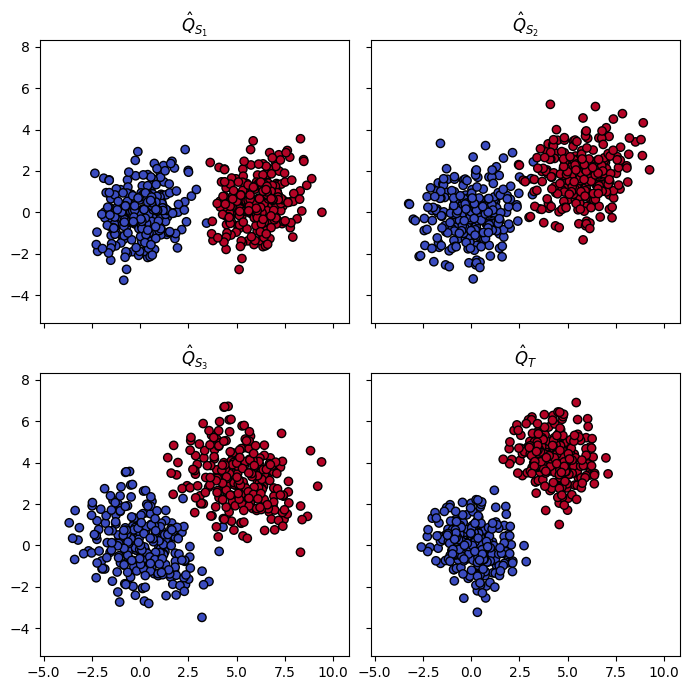

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(Xs, Ys, axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
# ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c='gray', edgecolor='k')
ax.scatter(x=Xt[::2, 0], y=Xt[::2, 1], c=Yt[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [50]:
MQ, SQ, BQ = [], [], []
for Xsk, Ysk in zip(Xs, Ys):
    MQ.append(torch.stack([
        Xsk[Ysk.argmax(dim=1) == c].mean(dim=0) for c in range(n_classes)
    ]))
    
    SQ.append(torch.stack([
        Xsk[Ysk.argmax(dim=1) == c].std(dim=0) for c in range(n_classes)
    ]))
    
    BQ.append(estimate_proportions(Ysk))
MQ = torch.stack(MQ)
SQ = torch.stack(SQ)
BQ = torch.stack(BQ)

In [51]:
gmm_t = GaussianMixture(n_components=2, covariance_type='diag')
gmm_t.fit(Xt)

GaussianMixture(covariance_type='diag', n_components=2)

In [52]:
MQ = torch.cat([MQ, torch.from_numpy(gmm_t.means_.reshape(1, 2, 2)).float()])
SQ = torch.cat([SQ, torch.from_numpy(np.sqrt(gmm_t.covariances_).reshape(1, 2, 2)).float()])
BQ = torch.cat([BQ, torch.from_numpy(gmm_t.weights_).unsqueeze(0).float()])

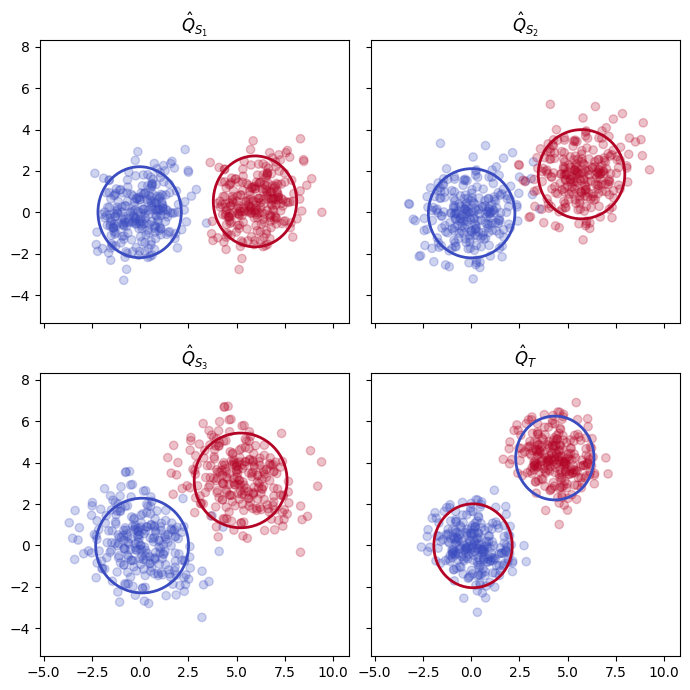

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for l in range(n_datasets):
    for c in range(n_classes):
        plot_cov_ellipse(pos=MQ[l, c],
                         cov=np.diag(SQ[l, c]),
                         ax=axes.flatten()[l],
                         c=colors[c])

        axes.flatten()[l].set_xlim([xmin - 1, xmax + 1])
        axes.flatten()[l].set_ylim([ymin - 1, ymax + 1])

for i, (Xi, Yi, ax) in enumerate(zip(Xs, Ys, axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', alpha=0.25)
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
ax.scatter(x=Xt[::2, 0], y=Xt[::2, 1], c=Yt[::2, 1], cmap='coolwarm', alpha=0.25)
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

plt.savefig('../Figures/examples/gmm-dadil/InitialFit.pdf', transparent=True)

In [54]:
gmm_dadil = GaussianMixtureDictionary(
     n_distributions=len(Xs) + 1,
     n_dim=2,
     n_classes=2,
     n_components=n_components,
     weight_initialization='uniform',
     learning_rate_atoms=1e-1,
     learning_rate_weights=1e-1,
     weight_dil=1.0,
     weight_gmm=1.0,
     domain_names=None,
     optimizer_name='adam',
     tensor_dtype=torch.float32,
     track_atoms=True,
     schedule=False,
     momentum=0.9
)

In [55]:
all_X = Xs + [Xt]
gmm_dadil.fit_log_likelihood(BQ[:-1], MQ[:-1], SQ[:-1], all_X, n_iter_max=500)

It 0/500, Loss: 68.39476776123047
It 1/500, Loss: 59.643287658691406
It 2/500, Loss: 53.20067596435547
It 3/500, Loss: 48.358604431152344
It 4/500, Loss: 44.6458740234375
It 5/500, Loss: 41.74650573730469
It 6/500, Loss: 39.446380615234375
It 7/500, Loss: 37.59834289550781
It 8/500, Loss: 36.09889221191406
It 9/500, Loss: 34.87261199951172
It 10/500, Loss: 33.86210632324219
It 11/500, Loss: 33.0222282409668
It 12/500, Loss: 32.316680908203125
It 13/500, Loss: 31.715734481811523
It 14/500, Loss: 31.194480895996094
It 15/500, Loss: 30.731685638427734
It 16/500, Loss: 30.309288024902344
It 17/500, Loss: 29.912372589111328
It 18/500, Loss: 29.529319763183594
It 19/500, Loss: 29.151838302612305
It 20/500, Loss: 28.774795532226562
It 21/500, Loss: 28.395771026611328
It 22/500, Loss: 28.014516830444336
It 23/500, Loss: 27.632347106933594
It 24/500, Loss: 27.25148582458496
It 25/500, Loss: 26.874439239501953
It 26/500, Loss: 26.503324508666992
It 27/500, Loss: 26.139291763305664
It 28/500, Los

It 228/500, Loss: 15.707685470581055
It 229/500, Loss: 15.707634925842285
It 230/500, Loss: 15.707587242126465
It 231/500, Loss: 15.707541465759277
It 232/500, Loss: 15.707496643066406
It 233/500, Loss: 15.70745849609375
It 234/500, Loss: 15.707418441772461
It 235/500, Loss: 15.707381248474121
It 236/500, Loss: 15.707348823547363
It 237/500, Loss: 15.707315444946289
It 238/500, Loss: 15.70728588104248
It 239/500, Loss: 15.707257270812988
It 240/500, Loss: 15.707231521606445
It 241/500, Loss: 15.707206726074219
It 242/500, Loss: 15.707182884216309
It 243/500, Loss: 15.707160949707031
It 244/500, Loss: 15.70713996887207
It 245/500, Loss: 15.707121849060059
It 246/500, Loss: 15.707104682922363
It 247/500, Loss: 15.7070894241333
It 248/500, Loss: 15.707074165344238
It 249/500, Loss: 15.707059860229492
It 250/500, Loss: 15.707047462463379
It 251/500, Loss: 15.70703411102295
It 252/500, Loss: 15.707023620605469
It 253/500, Loss: 15.707013130187988
It 254/500, Loss: 15.707003593444824
It 255/

It 490/500, Loss: 15.706860542297363
It 491/500, Loss: 15.70686149597168
It 492/500, Loss: 15.706860542297363
It 493/500, Loss: 15.706859588623047
It 494/500, Loss: 15.706860542297363
It 495/500, Loss: 15.706860542297363
It 496/500, Loss: 15.706860542297363
It 497/500, Loss: 15.70686149597168
It 498/500, Loss: 15.70686149597168
It 499/500, Loss: 15.706862449645996


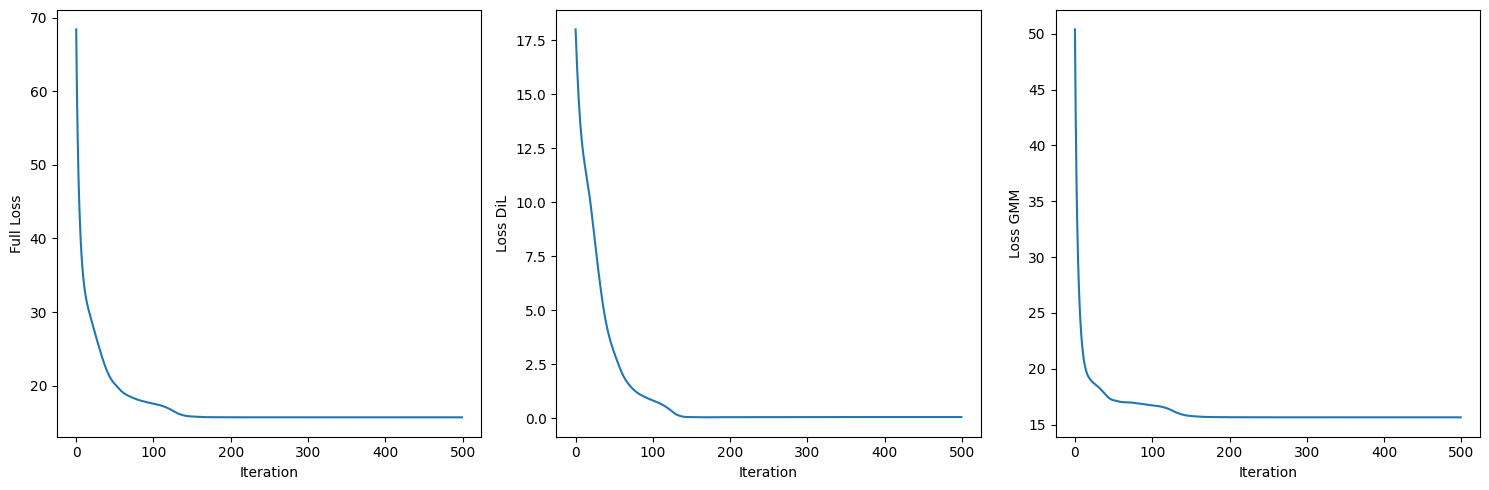

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(gmm_dadil.history['loss'])
axes[0].set_ylabel('Full Loss')
axes[0].set_xlabel('Iteration')

axes[1].plot(gmm_dadil.history['loss_dil'])
axes[1].set_ylabel('Loss DiL')
axes[1].set_xlabel('Iteration')

axes[2].plot(gmm_dadil.history['loss_gmm'])
axes[2].set_ylabel('Loss GMM')
axes[2].set_xlabel('Iteration')

plt.tight_layout()

plt.savefig('../Figures/examples/gmm-dadil/LossGMM-DaDiL.pdf', transparent=True)

In [57]:
means = gmm_dadil.means.detach().numpy()
stds = gmm_dadil.stds.detach().numpy()

In [58]:
mean_hist = torch.stack([elem['means'].detach() for elem in gmm_dadil.history['atoms']])[::2]
std_hist = torch.stack([elem['stds'].detach() for elem in gmm_dadil.history['atoms']])[::2]

In [59]:
mean_hist.shape

torch.Size([250, 2, 2, 2])

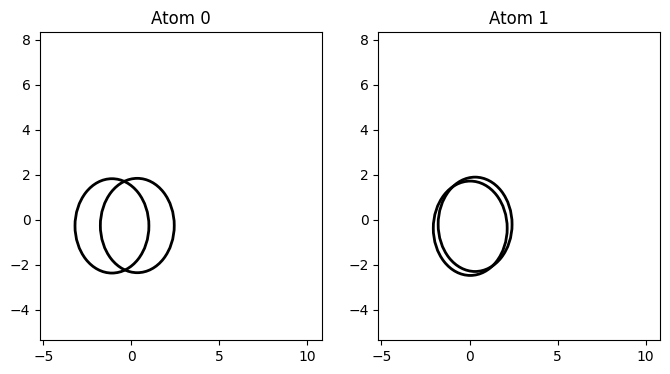

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for k in range(n_components):
    for c in range(n_classes):
        plot_cov_ellipse(pos=mean_hist[0, k, c],
                         cov=np.diag(std_hist[0, k, c]),
                         ax=axes.flatten()[k])

    axes.flatten()[k].set_xlim([xmin - 1, xmax + 1])
    axes.flatten()[k].set_ylim([ymin - 1, ymax + 1])
    axes.flatten()[k].set_title("Atom {}".format(k))

def update(frame):
    m, s = frame
    # clear the axis each frame
    for ax in axes.flatten():
        ax.clear()
    
    for k in range(n_components):
        for c in range(n_classes):
            plot_cov_ellipse(pos=m[k, c],
                             cov=np.diag(s[k, c]),
                             ax=axes.flatten()[k])

        axes.flatten()[k].set_xlim([xmin - 1, xmax + 1])
        axes.flatten()[k].set_ylim([ymin - 1, ymax + 1])
        axes.flatten()[k].set_title("Atom {}".format(k))


anim = FuncAnimation(fig, update, frames=[(m, s) for m, s in zip(mean_hist, std_hist)], interval=300)

In [61]:
writervideo = animation.FFMpegWriter(fps=60)
anim.save('../Figures/examples/gmm-dadil/fit_history.mp4', writer=writervideo)
plt.close()

In [62]:
whist = torch.stack(gmm_dadil.history['weights'])

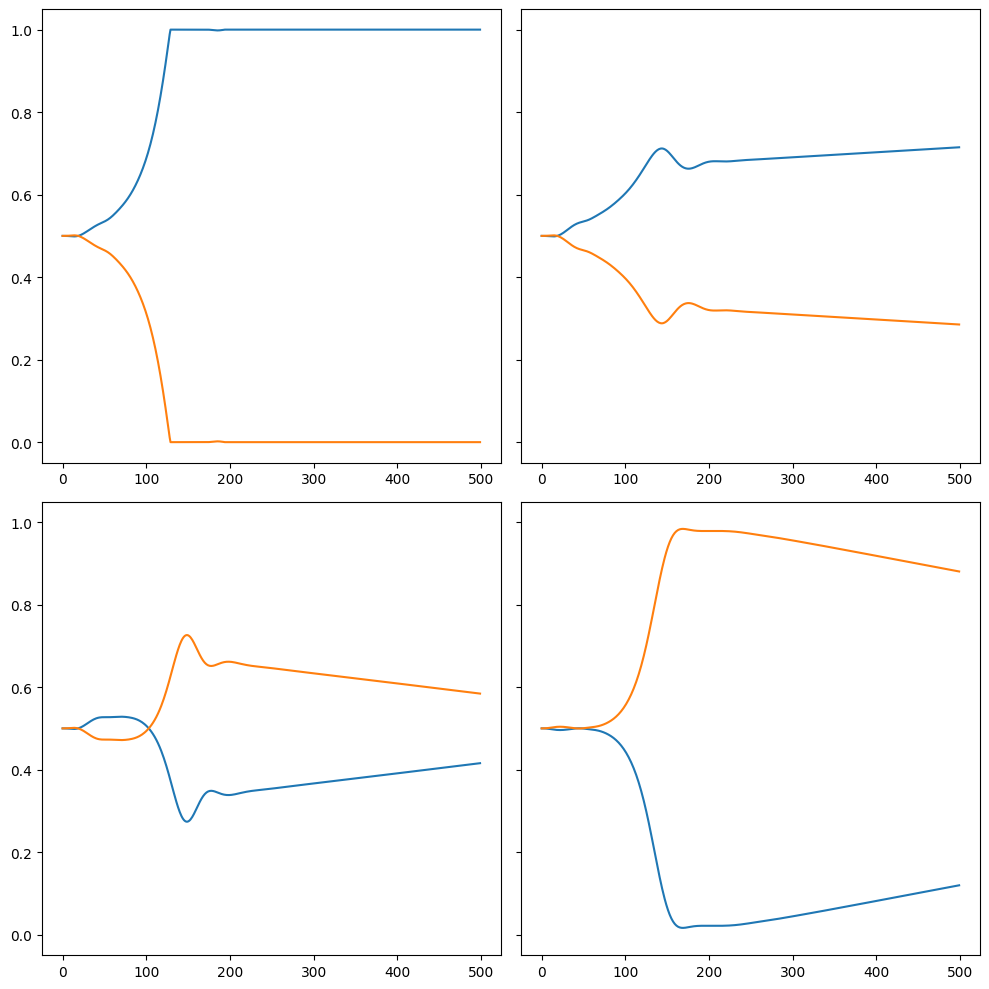

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

for k, ax in enumerate(axes.flatten()):
    ax.plot(whist[:, k, :])
    
plt.tight_layout()

In [64]:
gmm_dadil.A

Parameter containing:
tensor([[1.0000, 0.0000],
        [0.7148, 0.2852],
        [0.4156, 0.5844],
        [0.1196, 0.8804]], requires_grad=True)

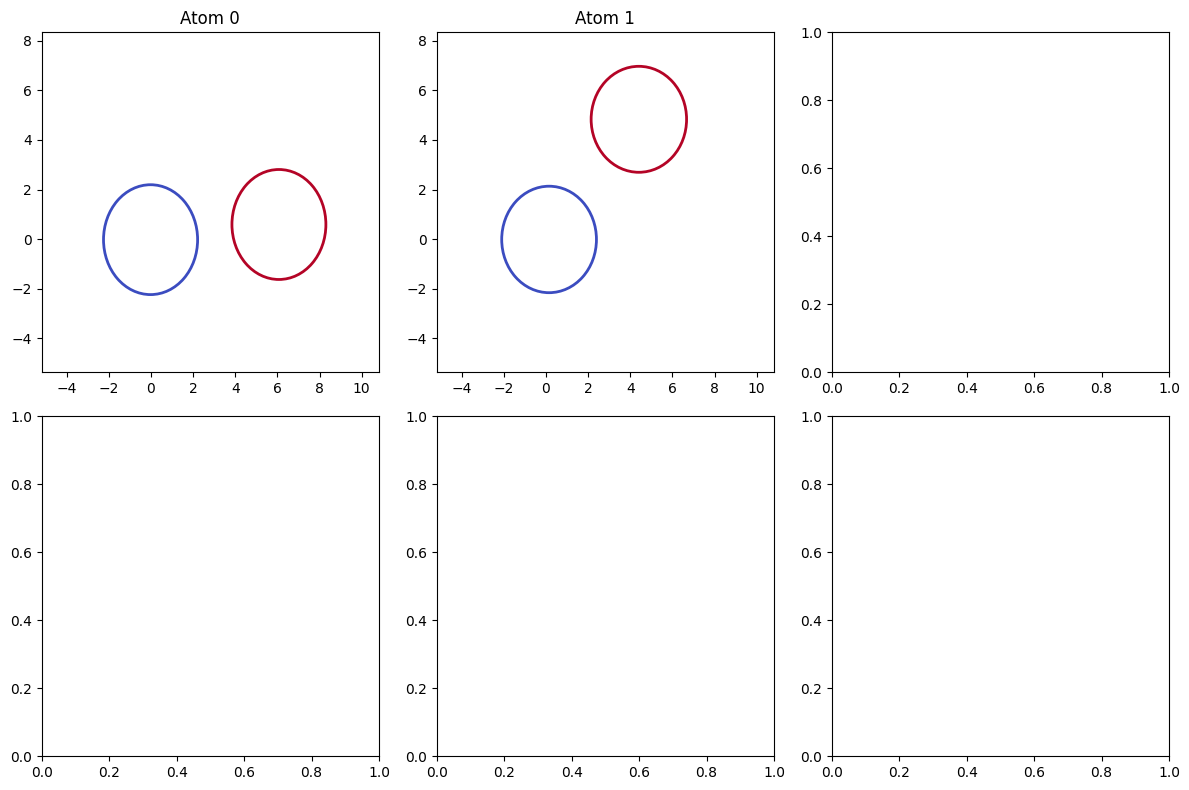

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for k in range(n_components):
    for c in range(n_classes):
        plot_cov_ellipse(pos=means[k, c],
                         cov=np.diag(stds[k, c]),
                         ax=axes.flatten()[k],
                         c=colors[c])

    axes.flatten()[k].set_xlim([xmin - 1, xmax + 1])
    axes.flatten()[k].set_ylim([ymin - 1, ymax + 1])
    axes.flatten()[k].set_title("Atom {}".format(k))
plt.tight_layout()

<AxesSubplot: >

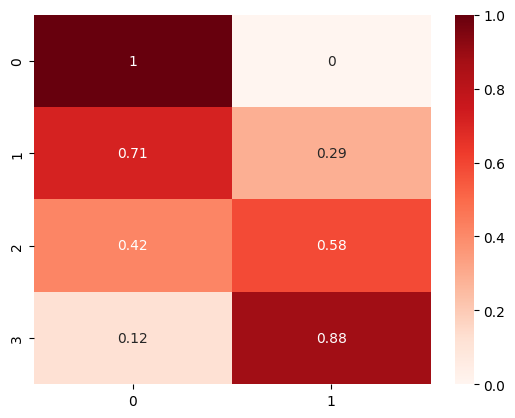

In [66]:
sns.heatmap(gmm_dadil.A.detach(), cmap='Reds', annot=True)

In [67]:
MB = torch.einsum('lk,kcd->lcd', gmm_dadil.A[:-1], gmm_dadil.means).detach()
SB = torch.einsum('lk,kcd->lcd', gmm_dadil.A[:-1], gmm_dadil.stds).detach()
BB = torch.einsum('lk,kc->lc', gmm_dadil.A[:-1], gmm_dadil.class_weights).detach()

Mt = torch.einsum('k,kcd->cd', gmm_dadil.A[-1], gmm_dadil.means).detach()
St = torch.einsum('k,kcd->cd', gmm_dadil.A[-1], gmm_dadil.stds).detach()
Bt = torch.einsum('k,kc->c', gmm_dadil.A[-1], gmm_dadil.class_weights).detach()

Mr = torch.cat([MB, Mt[None, ...]], dim=0)
Sr = torch.cat([SB, St[None, ...]], dim=0)
Br = torch.cat([BB, Bt[None, ...]], dim=0)

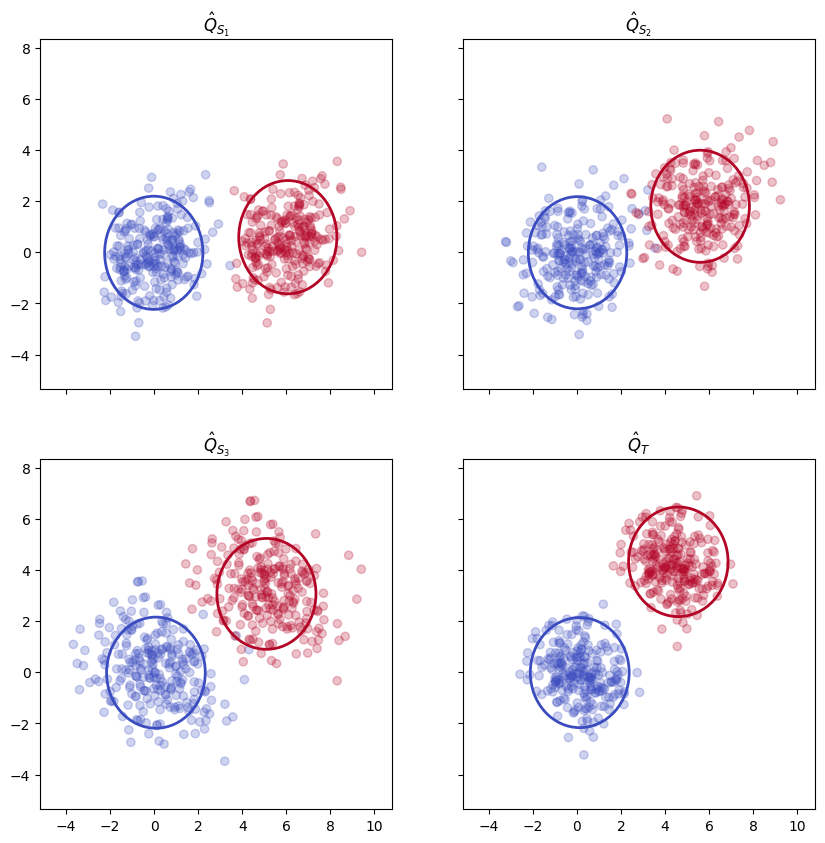

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for l in range(n_datasets):
    for c in range(n_classes):
        plot_cov_ellipse(pos=Mr[l, c],
                         cov=np.diag(Sr[l, c]),
                         ax=axes.flatten()[l],
                         c=colors[c])

        axes.flatten()[l].set_xlim([xmin - 1, xmax + 1])
        axes.flatten()[l].set_ylim([ymin - 1, ymax + 1])
        
for i, (Xi, Yi, ax) in enumerate(zip(Xs, Ys, axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', alpha=0.25)
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
# ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c='gray', edgecolor='k')
ax.scatter(x=Xt[::2, 0], y=Xt[::2, 1], c=Yt[::2, 1], cmap='coolwarm', alpha=0.25)
ax.set_title(r"$\hat{Q}_{T}$")
plt.savefig('../Figures/examples/gmm-dadil/DaDiLFit.pdf', transparent=True)